In [1]:
## Preliminaries

using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using AdvancedHMC
using ArviZ
using BumpCosmologyGWTC3
using CairoMakie
using Colors
using Cosmology
using DataFrames
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using InferenceObjects
using JSON
using LaTeXStrings
using MCMCChainsStorage
using NCDatasets
using PairPlots
using PolyLog
using PopModels
using Printf
using ProgressLogging
using Random
using StatsBase
using SpecialFunctions
using StatsFuns
using Trapz
using Turing
using Unitful
using UnitfulAstro
using UnitfulChainRules

include("plots.jl")

  Activating project at `~/GWTC4_35_m1m2z/Events`


h_plot (generic function with 1 method)

# Load GWTC-4 Parameter Estimation Samples

In [2]:
## Samples and Selection

## Set up paths
struct Paths
    gwtc_2_dir::String
    gwtc_3_dir::String
    evt_table_file::String
    O4a_dir::String
end

paths = Paths(
    "/mnt/home/ccalvk/ceph/GWTC-2.1", 
    "/mnt/home/ccalvk/ceph/GWTC-3", 
    "/mnt/home/ccalvk/ceph/gwosc-snapshots/snapshot-2023-11-04/GWTC/GWTC.json",
    "/mnt/home/sroy1/ceph/O4/O4a_final_PE"
)

## Output Directory for Plots and Astro Comparison Plot
outdir = "../figures/"

## Plot Specifications
xlabelsize = 28
ylabelsize = 28
xticklabelsize = 19
yticklabelsize = 19
titlesize = 35
draws = 500

plot_save = true

true

In [3]:
all_pe = load_pe(; gwtc_2_dir=paths.gwtc_2_dir, gwtc_3_dir=paths.gwtc_3_dir)
evt_table = load_event_table(paths.evt_table_file)
all_pe = join_pe_evt_tables(all_pe, evt_table)
all_pe = vcat(far_cut(all_pe), load_pe_from_dir_O4a(; dir=paths.O4a_dir); cols=:intersect)

┌ Info: Could not read IGWN-GWTC2p1-v2-GW190425_081805_PEDataRelease_mixed_nocosmo.h5
└ @ BumpCosmologyGWTC3 /mnt/home/sroy1/GWTC4_35_m1m2z/Events/src/load.jl:26
Loading IGWN HDF5 Files 100%|████████████████████████████| Time: 0:01:11


7380450×46 DataFrame
     Row │ spin_2y      dec         chirp_mass  redshift   theta_jn  ra        ⋯
         │ Float64      Float64     Float64     Float64    Float64   Float64   ⋯
─────────┼──────────────────────────────────────────────────────────────────────
       1 │  0.0157482   -1.2029        30.9684  0.0968552  2.77079   1.28323   ⋯
       2 │  0.306186    -1.17447       31.6976  0.0858721  2.58701   1.12687
       3 │ -0.281979    -1.20404       29.1559  0.0984072  2.65664   2.28386
       4 │ -0.0257892   -1.28148       29.4337  0.0788087  2.46328   1.66579
       5 │ -0.615255    -1.22545       28.3426  0.093687   2.78603   2.18355   ⋯
       6 │  0.0101604   -1.2815        30.2896  0.105684   2.71688   1.89592
       7 │ -0.0143139   -1.22618       30.8565  0.120825   2.83255   2.33255
       8 │ -0.00522301  -1.25144       29.8868  0.118836   3.04766   2.17208
    ⋮    │      ⋮           ⋮           ⋮           ⋮         ⋮         ⋮      ⋱
 7380444 │ -0.156125    -0.107231      26.5373  0.197542   1.71402   4.36708   ⋯
 7380445 │  0.170227    -0.3066        26.2908  0.270314   0.556646  1.33296
 7380446 │  0.466278    -0.82461       24.0682  0.312199   2.44664   3.3592
 7380447 │ -0.0826816    1.43077       23.5014  0.210579   2.34209   4.85127
 7380448 │  0.160161    -0.48862       24.3207  0.344435   0.394103  4.25592   ⋯
 7380449 │ -0.385012     1.02305       25.0985  0.277242   0.93985   1.11739
 7380450 │ -0.409703    -0.858967      26.6075  0.421572   3.04387   3.17181
                                             40 columns and 7380435 rows omitted

In [4]:
groups_all_pe = groupby(all_pe, :gwname)

GroupedDataFrame with 156 groups based on key: gwname
First Group (4478 rows): gwname = "GW150914_095045"
  Row │ spin_2y     dec       chirp_mass  redshift   theta_jn  ra        a_1   ⋯
      │ Float64     Float64   Float64     Float64    Float64   Float64   Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  0.0157482  -1.2029      30.9684  0.0968552   2.77079  1.28323   0.001 ⋯
    2 │  0.306186   -1.17447     31.6976  0.0858721   2.58701  1.12687   0.927
  ⋮   │     ⋮          ⋮          ⋮           ⋮         ⋮         ⋮          ⋮ ⋱
 4477 │  0.0103548  -1.25694     31.4251  0.105313    2.90354  1.93885   0.666
 4478 │  0.294413   -1.17306     30.8547  0.0798766   2.72162  0.991337  0.374
                                                40 columns and 4474 rows omitted
⋮
Last Group (29072 rows): gwname = "GW240109_050431"
   Row │ spin_2y     dec         chirp_mass  redshift  theta_jn  ra        a_1 ⋯
       │ Float64     Float64     Float64     Float64   Float64   Float64   Flo ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ -0.0077127   1.47431       24.7871  0.391154  2.7325    0.511963  0.1 ⋯
     2 │  0.710932    0.0802244     24.986   0.198692  1.21325   0.39309   0.1
   ⋮   │     ⋮           ⋮           ⋮          ⋮         ⋮         ⋮          ⋱
 29072 │ -0.409703   -0.858967      26.6075  0.421572  3.04387   3.17181   0.2
                                               40 columns and 29069 rows omitted

In [5]:
pe = mass_cut(all_pe, thresh=0.5)
groups = groupby(pe, :gwname)

GroupedDataFrame with 115 groups based on key: gwname
First Group (4478 rows): gwname = "GW150914_095045"
  Row │ spin_2y     dec       chirp_mass  redshift   theta_jn  ra        a_1   ⋯
      │ Float64     Float64   Float64     Float64    Float64   Float64   Float ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │  0.0157482  -1.2029      30.9684  0.0968552   2.77079  1.28323   0.001 ⋯
    2 │  0.306186   -1.17447     31.6976  0.0858721   2.58701  1.12687   0.927
  ⋮   │     ⋮          ⋮          ⋮           ⋮         ⋮         ⋮          ⋮ ⋱
 4477 │  0.0103548  -1.25694     31.4251  0.105313    2.90354  1.93885   0.666
 4478 │  0.294413   -1.17306     30.8547  0.0798766   2.72162  0.991337  0.374
                                                40 columns and 4474 rows omitted
⋮
Last Group (29052 rows): gwname = "GW240109_050431"
   Row │ spin_2y     dec         chirp_mass  redshift  theta_jn  ra        a_1 ⋯
       │ Float64     Float64     Float64     Float64   Float64   Float64   Flo ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │ -0.0077127   1.47431       24.7871  0.391154  2.7325    0.511963  0.1 ⋯
     2 │  0.710932    0.0802244     24.986   0.198692  1.21325   0.39309   0.1
   ⋮   │     ⋮           ⋮           ⋮          ⋮         ⋮         ⋮          ⋱
 29052 │ -0.409703   -0.858967      26.6075  0.421572  3.04387   3.17181   0.2
                                               40 columns and 29049 rows omitted

In [6]:
gw_names = [group.gwname[1] for group in groups]

open("../data/analyzed_gw_event_names.txt", "w") do io
    for name in gw_names
        println(io, name)
    end
end

println(gw_names)
println(length(gw_names))

SubString{String}["GW150914_095045", "GW151012_095443", "GW170104_101158", "GW170729_185629", "GW170809_082821", "GW170814_103043", "GW170818_022509", "GW170823_131358", "GW190408_181802", "GW190412_053044", "GW190413_052954", "GW190413_134308", "GW190421_213856", "GW190503_185404", "GW190512_180714", "GW190513_205428", "GW190517_055101", "GW190519_153544", "GW190521_074359", "GW190527_092055", "GW190602_175927", "GW190620_030421", "GW190630_185205", "GW190701_203306", "GW190706_222641", "GW190719_215514", "GW190727_060333", "GW190731_140936", "GW190803_022701", "GW190805_211137", "GW190828_063405", "GW190828_065509", "GW190910_112807", "GW190915_235702", "GW190925_232845", "GW190929_012149", "GW191109_010717", "GW191127_050227", "GW191215_223052", "GW191222_033537", "GW191230_180458", "GW200112_155838", "GW200128_022011", "GW200129_065458", "GW200208_130117", "GW200209_085452", "GW200216_220804", "GW200219_094415", "GW200224_222234", "GW200302_015811", "GW200311_115853", "GW230601_224

# Plot PE Samples
## $m_1-m_2$ Plane

┌ Info: Events will be plotted with p > 0.0, but reduced by alpha*=0.25 at thresholds p < 0.5
└ @ Main /mnt/home/sroy1/GWTC4_35_m1m2z/Events/scripts/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X11sdnNjb2RlLXJlbW90ZQ==.jl:22


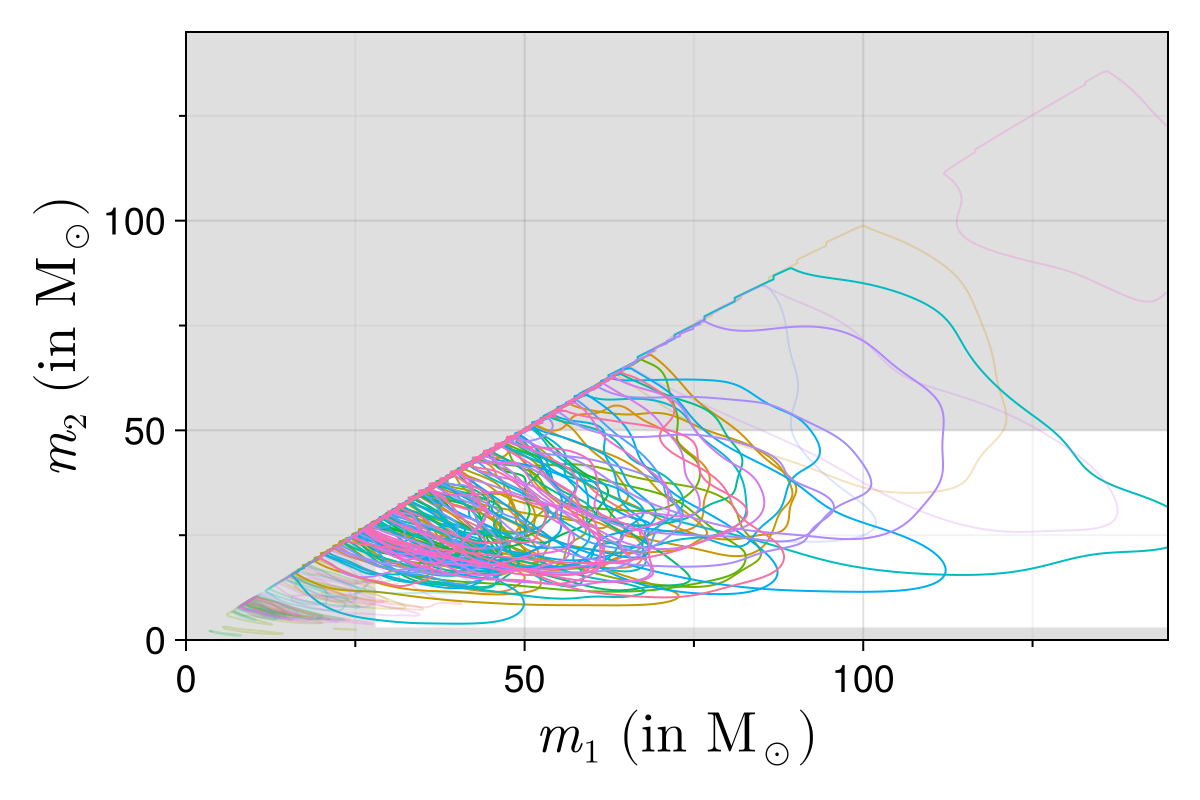

In [7]:
function frac_mass_bounds(df, m1_min, m2_min, m2_max)
    m1s = df[!, :mass_1_source]
    m2s = df[!, :mass_2_source]
    p_in = sum((m1s .> m1_min) .&& (m2s .> m2_min) .&& (m2s .< m2_max)) / length(m1s)
    p_in
end

function m1m2_kde_plot(df;
    m1_min = 20.0,
    m2_min = 3.0,
    m2_max = 50.0,
    include_legend=false,
    p_cut=[0.9, 0.5, 0.1],
    p_cut_eventlist=0.0,
    rng=Random.default_rng(),
    far_thresh=1,
    alpha_factor=0.25,
    level=0.1,
    draw_cut_lines=false
)
    if p_cut != p_cut_eventlist
        @info("Events will be plotted with p > $(p_cut_eventlist), but reduced by alpha*=$(alpha_factor) at thresholds p < $(p_cut)")
    end

    evt_groups = DataFrames.groupby(df, :gwname)

    # Only apply chirp mass and FAR filtering — no m1/m2 filter
    evt_groups = [
    evt for evt in evt_groups
    if frac_mass_bounds(evt, m1_min, m2_min, m2_max) >= p_cut_eventlist
]


    cs = categorical_palette(length(evt_groups))

    mlow = 0.0
    mhigh = 145.0

    f = Figure(size=(600, 400))
    a = Axis(f[1, 1];
        xlabel=L"m_1~\mathrm{(in~} \mathrm{M}_\odot)",
        ylabel=L"m_2~\mathrm{(in~} \mathrm{M}_\odot)",
        xlabelsize = xlabelsize,
        ylabelsize = ylabelsize,
        xticklabelsize = xticklabelsize,
        yticklabelsize = yticklabelsize,
        limits=(mlow,mhigh,mlow,mhigh),
        # title=L"\mathrm{PE~Pos}~(m_1>20\mathrm{M}_{\odot},~3\mathrm{M}_{\odot}<m_2<50\mathrm{M}_{\odot})>0.5",
        xminorgridvisible=true, xminorticksvisible=true,
        yminorgridvisible=true, yminorticksvisible=true
    )

    # Exclusion regions (shaded)
    if draw_cut_lines
        m1_min = 28.0
        m2_min = 3.0
        m2_max = 50.0

        poly!(a, [0.0, m1_min, m1_min], [0.0, 0.0, m1_min], color=(:grey, 0.25))
        poly!(a, [m1_min, m1_min, mhigh, mhigh], [0.0, m2_min , m2_min, 0.0], color=(:grey, 0.25))
        poly!(a, [m2_max, mhigh, mhigh], [m2_max, mhigh, m2_max], color=(:grey, 0.25))
    end

    # m1 < m2 region
    band!(a, [mlow, mhigh], [mlow, mhigh], [mhigh, mhigh], color=(:grey, 0.25))

    @progress for (i, evt) in enumerate(evt_groups)
        alpha = 1.0
        p = frac_mass_bounds(evt, m1_min, m2_min, m2_max)
        for pc in p_cut
            if p > pc
                break
            else
                alpha *= alpha_factor
            end
        end

        c = (cs[i], alpha)
        npe = size(evt, 1)
        ndraw = min(256, npe)
        draw_inds = randperm(rng, npe)[1:ndraw]

        evt_draw = evt[draw_inds, :]

        x = evt_draw[!, :mass_1_source]
        y = evt_draw[!, :mass_2_source]
        kde_pts = vcat(x', y')
        k = KDE(kde_pts)
        p_kde_pts = [pdf(k, [kde_pts[1,i], kde_pts[2,i]]) + pdf(k, [kde_pts[2,i], kde_pts[1,i]]) for i in axes(kde_pts, 2)]

        p = quantile(p_kde_pts, level)

        dx = maximum(x) - minimum(x)
        xgrid = range(minimum(x)-0.1*dx, maximum(x)+0.1*dx, length=128)

        dy = maximum(y) - minimum(y)
        ygrid = range(minimum(y)-0.1*dy, maximum(y)+0.1*dy, length=129)

        zgrid = [(x ≥ y ? pdf(k, [x, y]) + pdf(k, [y, x]) : zero(x)) for x in xgrid, y in ygrid]

        contour!(a, xgrid, ygrid, zgrid; levels=[p], color=c)
    end

    if include_legend
        Legend(f[2,1],
            [LineElement(color=cs[i], linestyle=nothing) for i in 1:length(evt_groups)],
            [evt[1, :gwname] for evt in evt_groups],
            nbanks=3)
    end

    return f
end

f = m1m2_kde_plot(all_pe; p_cut=0.5, p_cut_eventlist=0.0, draw_cut_lines=true)
if plot_save
    resize_to_layout!(f)  # adjusts the figure size to content
    save(outdir * "m1_m2_kde.pdf", f, px_per_unit = 3)
end
f

## $q$

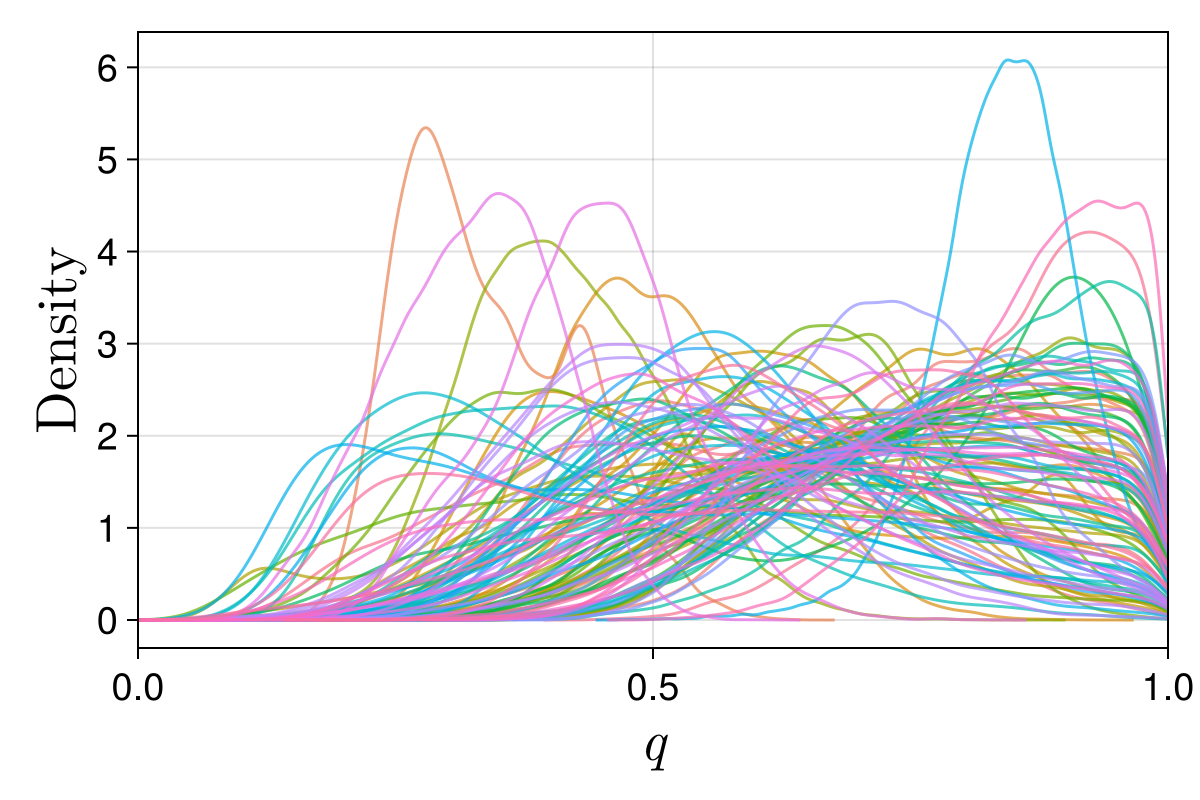

In [8]:
using KernelDensity

# Grouped data
pe_grouped = groups
cs = categorical_palette(length(pe_grouped))  # distinct colors

# Set up figure and axis
f = Figure(size=(600, 400))
a = Axis(f[1, 1],
    xlabel = L"q",
    ylabel = L"\mathrm{Density}",
    xlabelsize = xlabelsize,
    ylabelsize = ylabelsize,
    xticklabelsize = xticklabelsize,
    yticklabelsize = yticklabelsize,
    limits = (0, 1, nothing, nothing)  # x from 0 to 1, y auto
)

# Plot all PE redshift KDEs in distinct colors
for (i, evt) in enumerate(pe_grouped)
    q = evt.mass_ratio
    if length(q) < 2
        continue
    end
    kde_result = kde(q)
    lines!(a, kde_result.x, kde_result.density, color = (cs[i], 0.7))
end

# Save the figure
if plot_save
    save(outdir * "q_kde.pdf", f, px_per_unit = 3)
end
f

## $m_1-z$ Space

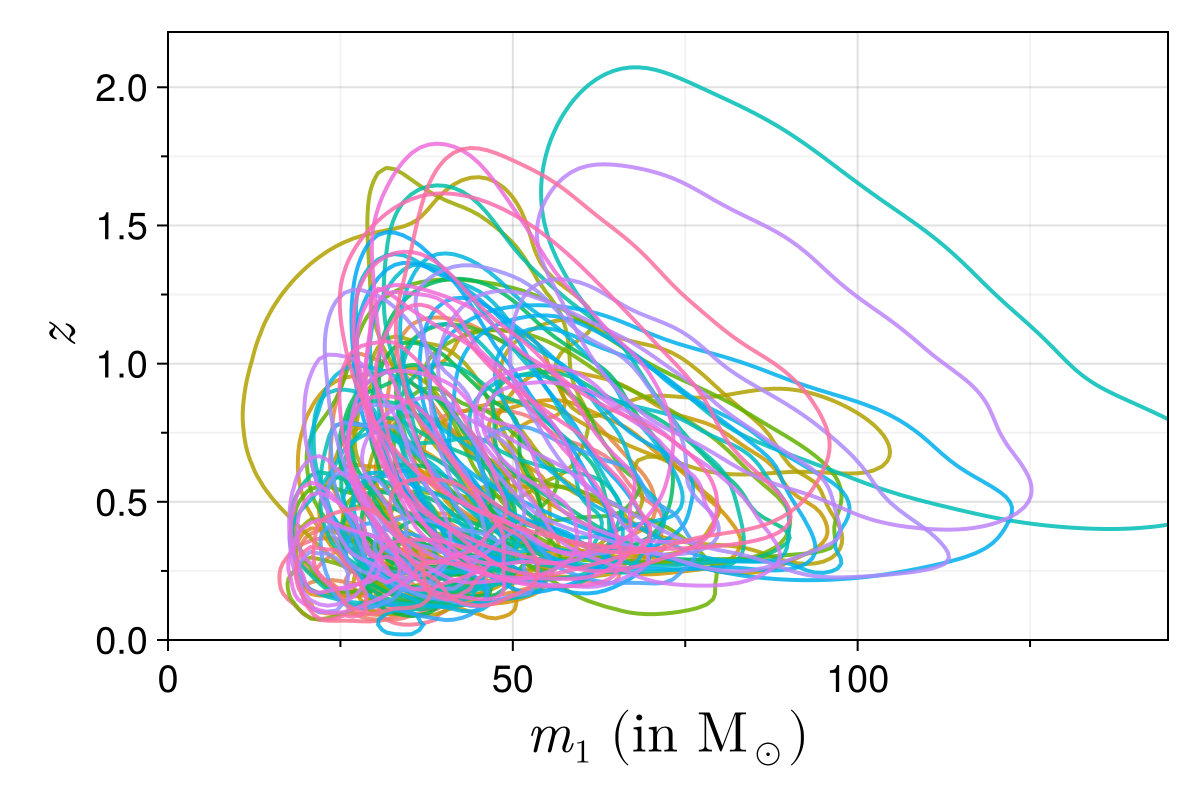

In [9]:
using Random, Statistics, DataFrames, KernelDensity, CairoMakie

# ---------- HDR threshold by enclosed probability mass ----------
function hdr_threshold(D::AbstractMatrix, xg::AbstractVector, zg::AbstractVector; mass=0.10)
    dx = step(xg); dz = step(zg)
    w  = dx*dz
    d  = vec(D)
    ord = sortperm(d, rev=true)
    cum = cumsum(@view d[ord]) .* w
    tot = sum(d) * w
    target = mass * tot
    k = findfirst(>=(target), cum)
    isnothing(k) && return minimum(d)  # fallback
    return d[ord[k]]
end

# ---------- KDE on (m1, log1p(z)) with Jacobian back-transform ----------
function kdegrid_m1_z_sane(m1::AbstractVector, z::AbstractVector;
                           xlims=(0.0,135.0), zlims=(0.0,2.0),
                           ngrid=(120,120), bw::Union{Nothing,Tuple{<:Real,<:Real}}=nothing)
    keep = map(i -> isfinite(m1[i]) && isfinite(z[i]) && z[i] ≥ 0, eachindex(m1))
    x = collect(Float64, m1[keep]); zz = collect(Float64, z[keep])
    if isempty(x)
        xg = range(xlims[1], xlims[2], length=2)
        zg = range(zlims[1], zlims[2], length=2)
        return (xg, zg, fill(0.0, 2, 2))
    end

    t = log1p.(zz)
    # Non-FFT KDE (stable)
    kd = isnothing(bw) ? kde((x, t)) : kde((x, t); bandwidth=bw)

    # Evaluation grid inside the box
    xg = range(xlims[1], xlims[2], length=ngrid[1])
    zg = range(zlims[1], zlims[2], length=ngrid[2])
    tg = log1p.(zg)

    # Evaluate pdf on grid with broadcasting; apply Jacobian 1/(1+z)
    # Create 2D meshes via broadcasting (no explicit loops)
    D_t = [pdf(kd, xx, tt) for xx in xg, tt in tg]
    D   = D_t ./ reshape(1 .+ zg, 1, :)
    return xg, zg, D
end

# ---------- Plot per group ----------
rng = Random.Xoshiro(0xaf91589a0f32ada4)
pe_grouped = groups                          # your grouped DataFrames
cs = categorical_palette(length(pe_grouped))

f = Figure(size=(600, 400))
a = Axis(f[1, 1];
    xlabel = L"m_1~\mathrm{(in~}\mathrm{M}_\odot)",
    ylabel = L"z",
    xlabelsize = xlabelsize, ylabelsize = ylabelsize,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    limits = ((0.0, 145.0), (0.0, 2.2)),
    xminorgridvisible=true, xminorticksvisible=true,
    yminorgridvisible=true, yminorticksvisible=true
)

const NDRAW_CAP = 400         # tune: 250–600
const GRID       = (120,120)  # tune: (100,100) faster, (150,150) smoother
const HDR_MASS   = 0.90       # 90% HDR boundary (common choice)

@progress for (i, evt) in enumerate(pe_grouped)
    npe = nrow(evt); npe == 0 && continue
    # light subsample to stabilize runtime
    ndraw = min(NDRAW_CAP, npe)
    idx = rand(rng, 1:npe, ndraw)
    e = evt[idx, :]
    e = filter(:mass_ratio => q -> q ≤ 1, e)
    isempty(e) && continue

    # (optional) a gentle rule-of-thumb bandwidth in (m1, t)
    x = e.mass_1_source; t = log1p.(e.redshift)
    n = length(x)
    if n < 10; continue; end
    # Scott’s rule 1.06*σ*n^(-1/6)
    bwx = 1.06 * std(x) * n^(-1/6)
    bwt = 1.06 * std(t) * n^(-1/6)

    xg, zg, D = kdegrid_m1_z_sane(e.mass_1_source, e.redshift;
                                  xlims=(0.0,145.0), zlims=(0.0,2.2),
                                  ngrid=GRID, bw=(bwx, bwt))

    level = hdr_threshold(D, xg, zg; mass=HDR_MASS)
    contour!(a, xg, zg, D; levels=[level], color=(cs[i], 0.85), linewidth=2)
end

# Save
if plot_save
    resize_to_layout!(f)
    save(outdir * "m1_z_kde.pdf", f, px_per_unit = 3)
end
f

## $q-z$ Space

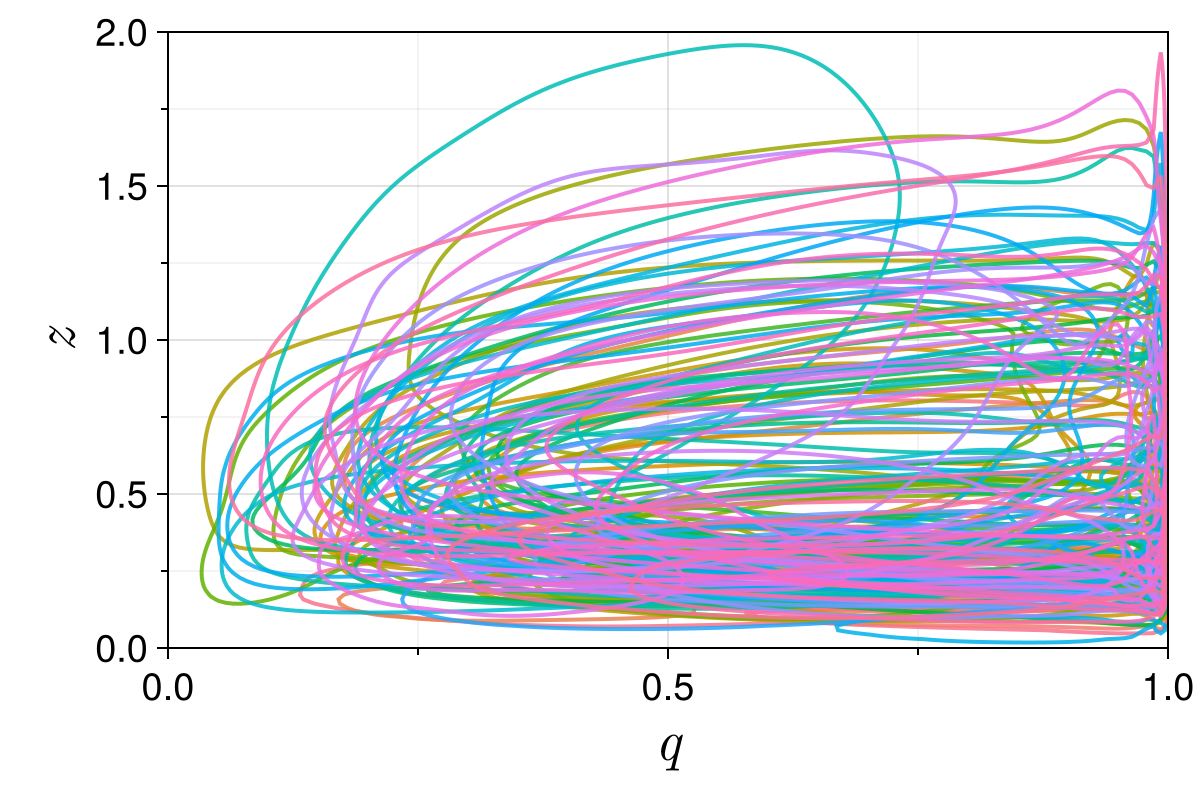

In [10]:
using Random, Statistics, DataFrames, KernelDensity, CairoMakie

# =============================== Tunables ===============================
const NDRAW_CAP = 500             # subsample per event for speed (↑ for smoother)
const GRID       = (140, 140)     # evaluation grid (nx, nz)
const HDR_MASSES = (0.90,)        # draw these HDR mass contours (e.g., (0.5, 0.9))
const EPS_Q      = 1e-6           # keep q away from 0/1 to avoid ±Inf in logit
const ZLIMS      = (0.0, 2.0)     # z plot limits
const QLIMS      = (0.0, 1.0)     # q plot limits
# =======================================================================

# ---------- HDR threshold by enclosed probability mass ----------
function hdr_threshold(D::AbstractMatrix, xg::AbstractVector, yg::AbstractVector; mass=0.90)
    dx = step(xg); dy = step(yg)
    w  = dx * dy
    d  = vec(D)
    ord = sortperm(d, rev=true)
    cum = cumsum(@view d[ord]) .* w
    tot = sum(d) * w
    target = mass * tot
    k = findfirst(>=(target), cum)
    isnothing(k) && return minimum(d)
    return d[ord[k]]
end

# ---------- KDE on (u=logit(q), t=log1p(z)), back to (q,z) ----------
# Returns (qgrid, zgrid, density(q,z))
function kdegrid_q_z(q::AbstractVector, z::AbstractVector;
                     qlims=(0.0, 1.0), zlims=(0.0, 2.0),
                     ngrid::Tuple{Int,Int}=(140,140),
                     bw::Union{Nothing,Tuple{<:Real,<:Real}}=nothing,
                     eps::Float64=1e-6)

    # keep finite & in-domain (q in (0,1), z >= 0)
    keep = map(i -> isfinite(q[i]) && isfinite(z[i]) && 0.0 < q[i] < 1.0 && z[i] ≥ 0.0,
               eachindex(q))
    qq = q[keep]; zz = z[keep]
    if isempty(qq)
        qg = range(max(qlims[1], eps), min(qlims[2], 1 - eps), length=2)
        zg = range(zlims[1], zlims[2], length=2)
        return (qg, zg, fill(0.0, 2, 2))
    end

    # clip q slightly from 0/1 for stability
    qq = clamp.(qq, eps, 1 - eps)

    # transforms
    logit(x) = log(x / (1 - x))
    u = logit.(qq)
    t = log1p.(zz)

    # KDE in (u, t) (non-FFT, stable)
    kd = isnothing(bw) ? kde((u, t)) : kde((u, t); bandwidth=bw)

    # grids in data space (q, z), then map to (u, t)
    qg = range(max(qlims[1], eps), min(qlims[2], 1 - eps), length=ngrid[1])
    zg = range(zlims[1], zlims[2], length=ngrid[2])
    ug = logit.(qg)
    tg = log1p.(zg)

    # evaluate on grid, apply joint Jacobian 1 / ((q*(1-q)) * (1+z))
    D_ut = [pdf(kd, uu, tt) for uu in ug, tt in tg]              # (nq × nz)
    J    = (qg .* (1 .- qg)) .* (1 .+ reshape(zg, 1, :))         # (nq × nz)
    D    = D_ut ./ J

    return qg, zg, D
end

# ----------------------------- Plot per group ----------------------------
# Assumes you already have `groups` (e.g., groupby(df, :gwname))
rng = Random.Xoshiro(0xaf91589a0f32ada4)
pe_grouped = groups
cs = categorical_palette(length(pe_grouped))

f = Figure(size=(600, 400))
a = Axis(f[1, 1];
    xlabel = L"q",
    ylabel = L"z",
    xlabelsize = xlabelsize, ylabelsize = ylabelsize,
    xticklabelsize = xticklabelsize, yticklabelsize = yticklabelsize,
    limits = ((QLIMS[1], QLIMS[2]), (ZLIMS[1], ZLIMS[2])),
    xminorgridvisible = true, xminorticksvisible = true,
    yminorgridvisible = true, yminorticksvisible = true
)

@progress for (i, evt) in enumerate(pe_grouped)
    npe = nrow(evt); npe == 0 && continue

    # modest subsample for speed
    ndraw = min(NDRAW_CAP, npe)
    idx = rand(rng, 1:npe, ndraw)
    e = evt[idx, :]

    # keep valid q (0<q<=1)
    e = filter(:mass_ratio => q -> isfinite(q) && 0.0 < q <= 1.0, e)
    isempty(e) && continue

    q = e.mass_ratio
    z = e.redshift
    n = length(q)
    if n < 10
        continue
    end

    # Bandwidths: Scott’s rule in transform space (gently inflated)
    logit(x) = log(x / (1 - x))
    u = logit.(clamp.(q, EPS_Q, 1 - EPS_Q))
    t = log1p.(z)
    bwu = 1.06 * std(u) * n^(-1/6)
    bwt = 1.06 * std(t) * n^(-1/6)
    bwu *= 1.25
    bwt *= 1.25

    qg, zg, D = kdegrid_q_z(q, z;
                            qlims=QLIMS, zlims=ZLIMS,
                            ngrid=GRID, bw=(bwu, bwt), eps=EPS_Q)

    for (j, m) in enumerate(HDR_MASSES)
        level = hdr_threshold(D, qg, zg; mass=m)
        contour!(a, qg, zg, D; levels=[level], color=(cs[i], 0.85),
                 linewidth = (m ≥ 0.90 ? 2.0 : 1.0))
    end
end

# Save if desired (assumes `plot_save` & `outdir` exist in your session)
if plot_save
    resize_to_layout!(f)
    save(outdir * "q_z_kde.pdf", f, px_per_unit = 3)
end
f